In [1]:
import cv2
import sys
import os
import glob
import random
from skimage import data, exposure, img_as_float
import matplotlib.pyplot as plt
from Misc.MiscUtils import *
from Misc.DataUtils import *
import numpy as np
import time
import argparse
import shutil
from io import StringIO
import string
from termcolor import colored, cprint
import math as m
from tqdm import tqdm
import csv
from sklearn.preprocessing import StandardScaler
# Don't generate pyc codes
sys.dont_write_bytecode = True

import tensorflow as tf

from keras import backend as K

from keras.utils import Sequence
from keras.initializers import VarianceScaling
from keras.models import Sequential
from keras.layers import  Activation, Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, InputLayer
from keras import optimizers
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from sklearn.metrics import mean_absolute_error, mean_squared_error

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12813463532370176747
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11178580799754033650
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15836364934326682107
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7704202445
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14269016804339033380
physical_device_desc: "device: 0, name: GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
]
Num GPUs Available:  1


In [2]:
def L2_loss(y_true, y_pred):
    return K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1, keepdims=True))

path = "model1kOF.h5"
model = load_model(path, custom_objects={'L2_loss': L2_loss})





Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [3]:
# Load and Test All Data

In [4]:
# loads all data in csv

all_labels = pd.read_csv("/home/gokul/CMSC733/hgokul_p1/Phase2/Data/Train_synthetic/H4.csv", index_col =False)
all_labels = all_labels.to_numpy()
all_patchNames = pd.read_csv("/home/gokul/CMSC733/hgokul_p1/Phase2/Data/Train_synthetic/ImageFileNames.csv")
all_patchNames = all_patchNames.to_numpy()
print(len(all_patchNames),len(all_labels))

n=10 # do test for n values
X_test = []
for p in all_patchNames[:n]:
#     print(p)
    tPatchA = cv2.imread("/home/gokul/CMSC733/hgokul_p1/Phase2/Data/Train_synthetic/PA/"+ str(p[0]))[:,:,0]
    tPatchB = cv2.imread("/home/gokul/CMSC733/hgokul_p1/Phase2/Data/Train_synthetic/PB/"+ str(p[0]))[:,:,0]
    tPatch = np.dstack((tPatchA, tPatchB))    
    X_test.append(tPatch)
X_test = np.array(X_test)    
Y_true = all_labels[:n]

print(X_test.shape,Y_true.shape)

Y_pred = model.predict(X_test[:n])

mae = mean_absolute_error(Y_true[:n], Y_pred)
mae

4985 4985
(10, 128, 128, 2) (10, 8)


3.6472212970256805

# Visualisation

In [36]:
# functions 

def getCornersFromH4pt(corner1, H4pt):
    corners1 = np.array(corner1.copy())
    del_corners = H4pt.reshape(2,4).T
    corners2 = corners1 + del_corners
    return corners2

def drawCorners(image, corners, color):

    corners_ = np.array(corners.copy())
    r = corners_[2,:].copy()
    corners_[2,:] = corners_[3,:]
    corners_[3,:] = r
    corners_ = corners_.reshape(-1,1,2)
#     print(corners_)
    corners_ = corners_.astype(int)
    image_corners = cv2.polylines(image.copy(),[corners_],True,color, 4)
    return image_corners

def getHfromH4pt(corners1, H4pt):
#     print("H4pt is: ")
#     print(H4pt.reshape(2,4).T)

    del_corners = H4pt.reshape(2,4).T
    
    corners1 = np.array(corners1)
#     print("corner1 is: ")
#     print(corners1)

    corners2 = corners1 + del_corners
#     print("corner2 is: ")
#     print(corners2)

    H = cv2.getPerspectiveTransform(np.float32(corners1), np.float32(corners2))
#     print("H is:")
#     print(H)
    return H

def warpImage(img, corners, H):
    image = img.copy()
    h, w, _= image.shape

    corners_ = np.array(corners)
    corners_ = corners_.reshape((-1,1,2))

    image_transformed = cv2.warpPerspective(image, H, (w,h))
    corner_transformed = cv2.perspectiveTransform(np.float32(corners_), H)
    corner_transformed = corner_transformed.astype(int)
    
    return image_transformed, corner_transformed


In [6]:
path = '/home/gokul/CMSC733/hgokul_p1/Phase2/Data/Train_dummy/'
pointsList = np.load(path+'pointsList.npy')
H4True = pd.read_csv(path+'H4.csv', index_col = False)
H4True = H4True.to_numpy()
pointsList.shape, H4True.shape

((5000, 4, 2, 2), (5000, 8))

3.650761663913727


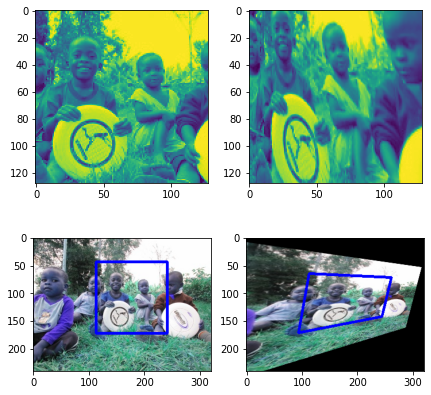

In [39]:

i = 69
pts1 = pointsList[i-1,:,:,0]
pts2 = pointsList[i-1,:,:,1]


imPathA = path + 'IA/' +str(i)+'.jpg'
# imPathB = path + 'IB/' +str(i)+'.jpg'
patchPathA = path + 'PA/' +str(i)+'.jpg' 
patchPathB = path + 'PB/' +str(i)+'.jpg'
imA = cv2.imread(imPathA)


H_AB = getHfromH4pt(pts1, H4True[i-1])
imB, pts2cal = warpImage(imA, pts1, H_AB)

# imB = cv2.imread(imPathB)
patchA = cv2.imread(patchPathA)
patchB = cv2.imread(patchPathB)

imA_corners = drawCorners(imA, pts1, (0,0,255))
imB_corners = drawCorners(imB, pts2cal, (0,0,255))

patchA = cv2.cvtColor(patchA, cv2.COLOR_BGR2GRAY)
patchB = cv2.cvtColor(patchB, cv2.COLOR_BGR2GRAY)
X = []
X.append(np.dstack((patchA,patchB)))
X = np.array(X)

y_true = H4True[i-1].reshape(-1,8)
y_pred = model.predict(X)

mae = mean_absolute_error(y_pred, y_true)
print(mae)

pts2pred = getCornersFromH4pt(pts1, y_pred)
# imA_corners = drawCorners(imA, pts1, (0,0,255))
imB_corners_pred = drawCorners(imB_corners, pts2pred, (0,255,0))

fx, plts = plt.subplots(2,2,figsize = (7,7))
plts[0][0].imshow(patchA)
plts[0][1].imshow(patchB)
plts[1][0].imshow(imA_corners)
plts[1][1].imshow(imB_corners)

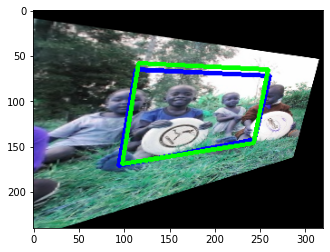

In [40]:
plt.imshow(imB_corners_pred)